In [2]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability
import _db_tools as db

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [3]:
#Data extraction
table_names = ['TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s', 'TOP_Passat_B9_limits_corrected_2023y_12m_13d_15h_47m_46s']
MEAS = retrieve_data("input.db", table_names[0])
LIMITS = retrieve_data("output.db", table_names[1])
LIMITS

Table *TOP_PASSAT_B9_measurements_2023y_12m_13d_14h_49m_51s* retrieved succesfully.
Table *TOP_Passat_B9_limits_corrected_2023y_12m_13d_15h_47m_46s* retrieved succesfully.


,LO_LIMIT,HI_LIMIT
0,0.313880,0.338880
1,0.333140,0.366740
2,0.318586,0.343586
3,0.341680,0.375280
4,0.326705,0.351705
5,0.349441,0.383041
6,0.313880,0.338880
7,0.333140,0.366740
8,0.318586,0.343586
9,0.341680,0.375280


In [4]:
MEAS_format = rename_index(MEAS); LIMITS_format = rename_index(LIMITS)
df = pd.concat([MEAS, LIMITS], axis=1)
df.columns = [f"Test: {i}" for i in range(1, df.shape[1]-1)] + ["LSL", "USL"]
df_format = pd.concat([MEAS_format, LIMITS_format], axis=1)
df_format.columns = [f"Test: {i}" for i in range(1, df_format.shape[1]-1)] + ["LSL", "USL"]
df_format

,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 42,Test: 43,Test: 44,Test: 45,Test: 46,Test: 47,Test: 48,Test: 49,LSL,USL
Guia_Luz_Blanco_FB1_X,0.3248,0.3261,0.3248,0.3252,0.3253,0.3249,0.3257,0.3256,0.3256,0.3244,...,0.3258,0.3241,0.3246,0.3253,0.3231,0.3244,0.3241,0.3249,0.313880,0.338880
Guia_Luz_Blanco_FB1_Y,0.3480,0.3489,0.3480,0.3491,0.3482,0.3485,0.3485,0.3497,0.3486,0.3476,...,0.3497,0.3481,0.3492,0.3497,0.3462,0.3479,0.3487,0.3483,0.333140,0.366740
Guia_Luz_Blanco_FB2_X,0.3340,0.3332,0.3313,0.3316,0.3329,0.3312,0.3326,0.3314,0.3330,0.3329,...,0.3312,0.3319,0.3307,0.3305,0.3305,0.3325,0.3305,0.3325,0.318586,0.343586
Guia_Luz_Blanco_FB2_Y,0.3590,0.3586,0.3568,0.3573,0.3584,0.3570,0.3582,0.3573,0.3586,0.3585,...,0.3573,0.3579,0.3571,0.3568,0.3565,0.3583,0.3569,0.3584,0.341680,0.375280
Guia_Luz_Blanco_FB3_X,0.3347,0.3385,0.3375,0.3383,0.3384,0.3383,0.3385,0.3384,0.3388,0.3387,...,0.3381,0.3383,0.3380,0.3384,0.3393,0.3384,0.3384,0.3390,0.326705,0.351705
Guia_Luz_Blanco_FB3_Y,0.3556,0.3659,0.3651,0.3658,0.3658,0.3657,0.3659,0.3659,0.3661,0.3661,...,0.3656,0.3657,0.3655,0.3658,0.3663,0.3658,0.3658,0.3663,0.349441,0.383041
Guia_Luz_Blanco_FB4_X,0.3247,0.3247,0.3250,0.3251,0.3244,0.3252,0.3247,0.3243,0.3246,0.3239,...,0.3234,0.3236,0.3235,0.3237,0.3238,0.3238,0.3233,0.3233,0.313880,0.338880
Guia_Luz_Blanco_FB4_Y,0.3463,0.3472,0.3467,0.3468,0.3471,0.3469,0.3474,0.3472,0.3464,0.3469,...,0.3468,0.3458,0.3462,0.3471,0.3463,0.3464,0.3468,0.3468,0.333140,0.366740
Guia_Luz_Blanco_FB5_X,0.3344,0.3318,0.3335,0.3336,0.3312,0.3334,0.3312,0.3315,0.3335,0.3310,...,0.3309,0.3333,0.3330,0.3311,0.3327,0.3332,0.3306,0.3309,0.318586,0.343586
Guia_Luz_Blanco_FB5_Y,0.3601,0.3585,0.3599,0.3599,0.3582,0.3599,0.3582,0.3585,0.3599,0.3582,...,0.3583,0.3598,0.3597,0.3583,0.3595,0.3599,0.3582,0.3582,0.341680,0.375280


In [5]:
#Calculate the specification values
    # means_df = rename_index(mean_calculator(MEAS) #Global means version
specification_means = mean_calculator(MEAS, glob.lenses_per_nest) #Mean per position version
specification_means_format = specification_means
resume = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns
fiber_values = resume[['mean', 'std']]
fiber_values = fiber_values.rename(columns={'mean': 'fiber mean'})
specification_limits = df.iloc[:, -2:]
specification_limits = specification_limits.rename(columns={49: "LSL", 50: "USL"})
specification_limits_format = specification_limits
specifications = pd.concat([specification_means_format, fiber_values, specification_limits_format], axis=1)
specifications_format = rename_index(specifications)
specifications_format

,mean,fiber mean,std,LSL,USL
Guia_Luz_Blanco_FB1_X,0.326380,0.324796,0.000645,0.313880,0.338880
Guia_Luz_Blanco_FB1_Y,0.349940,0.348498,0.000819,0.333140,0.366740
Guia_Luz_Blanco_FB2_X,0.331086,0.331855,0.001032,0.318586,0.343586
Guia_Luz_Blanco_FB2_Y,0.358480,0.357639,0.000739,0.341680,0.375280
Guia_Luz_Blanco_FB3_X,0.339205,0.338300,0.000599,0.326705,0.351705
Guia_Luz_Blanco_FB3_Y,0.366241,0.365596,0.001476,0.349441,0.383041
Guia_Luz_Blanco_FB4_X,0.326380,0.324008,0.000560,0.313880,0.338880
Guia_Luz_Blanco_FB4_Y,0.349940,0.346508,0.000577,0.333140,0.366740
Guia_Luz_Blanco_FB5_X,0.331086,0.332345,0.001178,0.318586,0.343586
Guia_Luz_Blanco_FB5_Y,0.358480,0.359124,0.000823,0.341680,0.375280


In [6]:
#Calculate the capability values
sigma = 6
analysis = capability_calculation(specifications, sigma)
analysis_format = rename_index(analysis)
analysis_format

,mean,fiber mean,std,LSL,USL,CAL_LO_LIMIT,CAL_HI_LIMIT,Cp,Cpk
Guia_Luz_Blanco_FB1_X,0.326380,0.324796,0.000645,0.313880,0.338880,0.3229,0.3267,6.455104,5.637018
Guia_Luz_Blanco_FB1_Y,0.349940,0.348498,0.000819,0.333140,0.366740,0.3460,0.3510,6.834077,6.247344
Guia_Luz_Blanco_FB2_X,0.331086,0.331855,0.001032,0.318586,0.343586,0.3288,0.3350,4.038255,3.789861
Guia_Luz_Blanco_FB2_Y,0.358480,0.357639,0.000739,0.341680,0.375280,0.3554,0.3599,7.580336,7.200721
Guia_Luz_Blanco_FB3_X,0.339205,0.338300,0.000599,0.326705,0.351705,0.3365,0.3401,6.956532,6.453106
Guia_Luz_Blanco_FB3_Y,0.366241,0.365596,0.001476,0.349441,0.383041,0.3612,0.3700,3.793176,3.647568
Guia_Luz_Blanco_FB4_X,0.326380,0.324008,0.000560,0.313880,0.338880,0.3223,0.3257,7.434568,6.023821
Guia_Luz_Blanco_FB4_Y,0.349940,0.346508,0.000577,0.333140,0.366740,0.3448,0.3482,9.712625,7.728392
Guia_Luz_Blanco_FB5_X,0.331086,0.332345,0.001178,0.318586,0.343586,0.3288,0.3359,3.535678,3.179657
Guia_Luz_Blanco_FB5_Y,0.358480,0.359124,0.000823,0.341680,0.375280,0.3567,0.3616,6.806592,6.545515


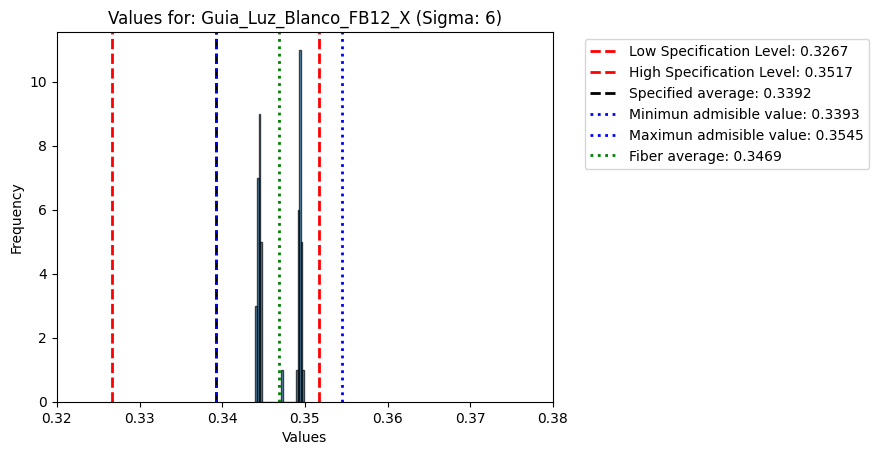

In [7]:
label = "Guia_Luz_Blanco_FB12_X"
plot_capability(MEAS_format, analysis_format, label, sigma, xrange=[0.32, 0.38])

In [8]:
##Data export
name = glob.tooling + "_capability_report_" + get_date() + ".xlsx"
confirmation = input("Do you want to export the data to a new Target.xlsx file and generate a new limits ini file? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output"), name)
    analysis_format.to_excel(output_filepath, index=True, header=True)
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Data exported inside: {output_filepath}')
else:
    print("Operation canceled.")

Operation canceled.
